In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from matplotlib.patches import Ellipse

Guess center: 6.19346632435464, 3.985612829951233
RMS: 2.7727533133182773, 2.6272113909799506
Semi-major axis: 0.6753193382008114
Semi-minor axis: 3.5527889296913884
Center: (6.298181497677068, 4.160871535314373)
Rotation angle: -0.8902916633372124


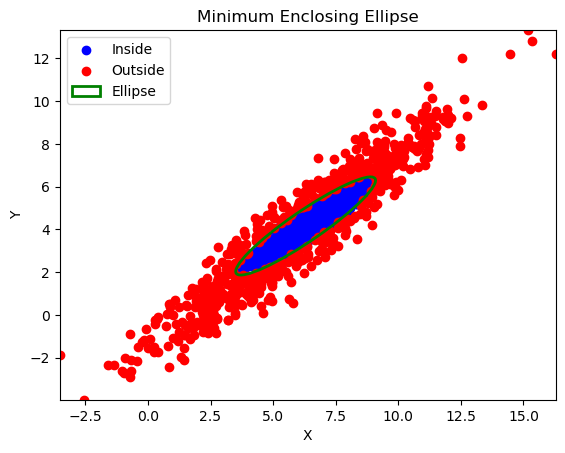

(0.6753193382008114,
 3.5527889296913884,
 -0.8902916633372124,
 6.298181497677068,
 4.160871535314373)

In [2]:
def ellipse_contains_point(a, b, theta, center, point):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    x, y = point
    x0, y0 = center
    
    term1 = ((cos_theta * (x - x0) + sin_theta * (y - y0)) ** 2) / (a ** 2)
    term2 = ((sin_theta * (x - x0) - cos_theta * (y - y0)) ** 2) / (b ** 2)
    
    return term1 + term2 <= 1

def ellipse_contains_point_noTrig(a, b, precalcTrig, center, point):
    x, y = point
    x0, y0 = center
    cos_theta, sin_theta = precalcTrig
    
    term1 = ((cos_theta * (x - x0) + sin_theta * (y - y0)) ** 2) / (a ** 2)
    term2 = ((sin_theta * (x - x0) - cos_theta * (y - y0)) ** 2) / (b ** 2)
    
    return term1 + term2 <= 1

def count_points_in_ellipse(a, b, theta, center, points):
    count = 0
    precalcTrig = (np.cos(theta), np.sin(theta))
    for point in points:
        #if ellipse_contains_point(a, b, theta, center, point):
        if ellipse_contains_point_noTrig(a, b, precalcTrig, center, point):
            count += 1

    #print(f"{a}, {b}, {theta}, {center} : {count}")
    
    return count

def objective(params, points, containedFrac):
    a, b, theta, x0, y0 = params
    center = (x0, y0)
    
    if a <= 0 or b <= 0:
        return np.inf

    numContainedPoints = count_points_in_ellipse(a, b, theta, center, points)
    
    if  numContainedPoints >= containedFrac*len(points):
        return a * b
        
    else:
        #return np.inf
        return (1e100)*(len(points) - numContainedPoints) #Instead of just giving infinity, give a number that allows for gradient

def find_minimum_enclosing_ellipse(points, containedFrac):
    rmsX = np.std(points[:,0])
    rmsY = np.std(points[:,1])
    rmsMax = max(rmsX, rmsY)
    
    guessCenterX = np.median(points[:,0])
    guessCenterY = np.median(points[:,1])

    print(f"Guess center: {guessCenterX}, {guessCenterY}")
    print(f"RMS: {rmsX}, {rmsY}")
    
    bounds = [
        (0, 10*rmsMax), 
        (0, 10*rmsMax), 
        (-np.pi / 2, np.pi / 2), 
        (np.min(points[:, 0]), np.max(points[:, 0])), 
        (np.min(points[:, 1]), np.max(points[:, 1]))
    ]

    totalPopSize = 100
    
    populationDE = np.zeros((totalPopSize, len(bounds)))

    populationDE[:, 0] = np.random.uniform(0, 2*rmsX, totalPopSize)
    populationDE[:, 1] = np.random.uniform(0, 2*rmsY, totalPopSize)
    populationDE[:, 2] = np.random.uniform(-np.pi / 4, np.pi / 4, totalPopSize)
    populationDE[:, 3] = np.random.normal(guessCenterX, rmsX, totalPopSize)
    populationDE[:, 4] = np.random.normal(guessCenterY, rmsY, totalPopSize)

    #To improve convergence, always have the naive starting guess
    populationDE[0] = [ 1*rmsX, 1*rmsY, 0, guessCenterX, guessCenterY ]
    populationDE[1] = [ 2*rmsX, 2*rmsY, 0, guessCenterX, guessCenterY ]
    populationDE[2] = [ 3*rmsX, 3*rmsY, 0, guessCenterX, guessCenterY ]
    
    result = differential_evolution(
        objective, 
        bounds, 
        args=(points, containedFrac), 
        maxiter=100, 
        #popsize=15, 
        init = populationDE, #"sobol" #Default is "latinhypercube"
        #tol=0.01, 
        polish=False,
    )
    
    # if result.success:
    #     a, b, theta, x0, y0 = result.x
    #     return a, b, theta, x0, y0
    # else:
    #     print("Optimization failed:", result.message)
    #     raise RuntimeError("Optimization failed")

    a, b, theta, x0, y0 = result.x
    return a, b, theta, x0, y0

def plot_ellipse_and_points(points, a, b, theta, x0, y0):
    fig, ax = plt.subplots()
    points = np.array(points)
    
    # Check each point and color accordingly
    inside_points = []
    outside_points = []
    for point in points:
        if ellipse_contains_point(a, b, theta, (x0, y0), point):
            inside_points.append(point)
        else:
            outside_points.append(point)
    
    inside_points = np.array(inside_points)
    outside_points = np.array(outside_points)
    
    if len(inside_points) > 0:
        ax.scatter(inside_points[:, 0], inside_points[:, 1], color='blue', label='Inside')
    if len(outside_points) > 0:
        ax.scatter(outside_points[:, 0], outside_points[:, 1], color='red', label='Outside')
    
    # Plot the ellipse
    ellipse = Ellipse((x0, y0), 2*a, 2*b, angle=np.degrees(theta), edgecolor='green', fc='None', lw=2, label='Ellipse')
    ax.add_patch(ellipse)
    
    ax.legend()

    # ax.set_xlim(min(points[:,0]) - 2*a, max(points[:,0]) + 2*a)
    # ax.set_ylim(min(points[:,1]) - 2*b, max(points[:,1]) + 2*b)
    ax.set_xlim(min(points[:,0]), max(points[:,0]))
    ax.set_ylim(min(points[:,1]), max(points[:,1]))
    #ax.set_aspect('equal')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Minimum Enclosing Ellipse')
    plt.show()

# Generate random points
mean = [2, 4]
cov = [[0.95**2, 0], [0, 2.6**2]]
num_points = 1000
points = np.random.multivariate_normal(mean, cov, num_points)

#Optional: transform
points = np.array([[x + y, y] for [x, y] in points])


containedFrac = 0.39
try:
    a, b, theta, x0, y0 = find_minimum_enclosing_ellipse(points, containedFrac)
    print(f"Semi-major axis: {a}")
    print(f"Semi-minor axis: {b}")
    print(f"Center: ({x0}, {y0})")
    print(f"Rotation angle: {theta}")
    plot_ellipse_and_points(points, a, b, theta, x0, y0)
except RuntimeError as e:
    print(e)

a, b, theta, x0, y0

In [3]:
a*b

2.3992670687663575

In [4]:
a*b/2.1**2

0.5440514895161809

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Loading default setLattice() values
Number of macro particles = 5000.0


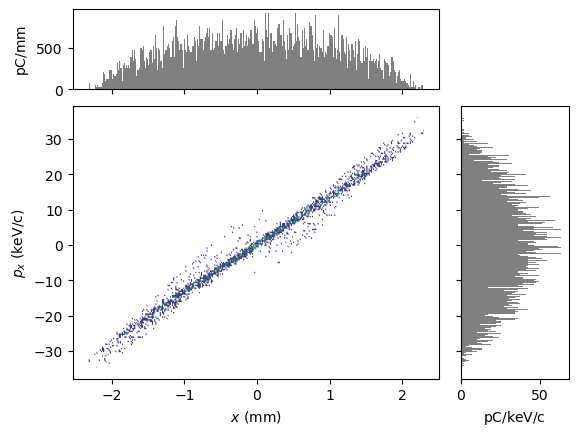

ParticleGroup with 5000 particles with total charge 1.9999999999999964e-09 C
3.5520205898890226e-06


In [5]:
from UTILITY_quickstart import *
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly_2023-05-16InjectorMatch.h5',
    inputBeamFilePathSuffix = '/beams/L0AFEND_facet2-lattice.h5',
    numMacroParticles = 5e3
)
trackBeam(tao)

P =  getBeamAtElement(tao, "L0AFEND")

display(plotMod(P, 'x', 'px',  bins=300));
plt.clf()

print(P)
print(P["norm_emit_x"])

Guess center: 0.005043418256028416, 0.009972013543628946
RMS: 1.0, 1.0
Semi-major axis: 0.1491911758217288
Semi-minor axis: 3.2021820186798906
Center: (-0.010723807989280423, -0.02733708149705906)
Rotation angle: -0.7762068061095415


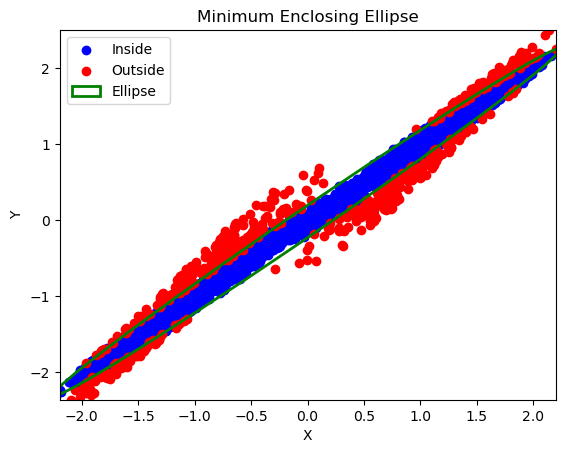

(0.1491911758217288,
 3.2021820186798906,
 -0.7762068061095415,
 -0.010723807989280423,
 -0.02733708149705906)

In [26]:
#points = np.column_stack((P.x, P.px))

#Optional: transform
#points = np.array([[x - y*0.002/30000, y] for [x, y] in points])



#Optional: Normalize
def normalize(data):
    return (data - np.mean(data)) / np.std(data)

points = np.column_stack((
    normalize(P.x), 
    normalize(P.px)
))

containedFrac = 0.9
try:
    a, b, theta, x0, y0 = find_minimum_enclosing_ellipse(points, containedFrac)
    print(f"Semi-major axis: {a}")
    print(f"Semi-minor axis: {b}")
    print(f"Center: ({x0}, {y0})")
    print(f"Rotation angle: {theta}")
    plot_ellipse_and_points(points, a, b, theta, x0, y0)
except RuntimeError as e:
    print(e)

a, b, theta, x0, y0

In [22]:
a*b / P.mass

4.1257192633131e-06

In [7]:
P["mean_gamma"]*a*b/2.1**2

3239.0668378172268

In [11]:
a*b/2.1**2

3.4106715851082012

In [9]:
import os

# Get the current working directory
current_directory = os.getcwd()

# List all files in the directory
files_in_directory = os.listdir(current_directory)

# Filter the list to include only files (optional)
files_only = [f for f in files_in_directory if os.path.isfile(os.path.join(current_directory, f))]

print("Files in the current working directory:")
for file in files_only:
    print(file)

Files in the current working directory:
2024-07-09 S3DF demo notebook.ipynb
UTILITY_plotMod.py
2024-07-01 Two bunch - toy injector matching.ipynb
setLattice_defaults.yml
2024-06-26 Testing quickstart utility.ipynb
2024-06-27 Testing UTILITY_impact.ipynb
.DS_Store
UTILITY_impact.py
UTILITY_linacPhaseAndAmplitude.py
2024-07-02 Testing new linac set script.ipynb
tmp.h5
2024-07-01 Nudge Macroparticle Weights.ipynb
2024-06-28 Quickstart with Impact - toy injector matching-Copy1.ipynb
UTILITY_quickstart.py
2024-07-03 Ellipse fitting.ipynb
2024-07-02 Testing setLattice config file.ipynb
2024-06-26 Testing quickstart utility - Impact two bunch.ipynb
bmadCondaEnv.yml
README.md
2024-07-02 Testing setLattice_defaults.ipynb
.gitignore
2024-06-26 Testing quickstart utility with Impact.ipynb
.gitattributes
2024-06-25 Ramp beam generation testing - W-chicane.ipynb
2024-07-01 RMS vs FWHM at PENT.ipynb
UTILITY_setLattice.py
UTILITY_modifyAndSaveInputBeam.py


# With normalization

In [ ]:
def ellipse_contains_point(a, b, theta, center, point):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    x, y = point
    x0, y0 = center
    
    term1 = ((cos_theta * (x - x0) + sin_theta * (y - y0)) ** 2) / (a ** 2)
    term2 = ((sin_theta * (x - x0) - cos_theta * (y - y0)) ** 2) / (b ** 2)
    
    return term1 + term2 <= 1

def ellipse_contains_point_noTrig(a, b, precalcTrig, center, point):
    x, y = point
    x0, y0 = center
    cos_theta, sin_theta = precalcTrig
    
    term1 = ((cos_theta * (x - x0) + sin_theta * (y - y0)) ** 2) / (a ** 2)
    term2 = ((sin_theta * (x - x0) - cos_theta * (y - y0)) ** 2) / (b ** 2)
    
    return term1 + term2 <= 1

def count_points_in_ellipse(a, b, theta, center, points):
    count = 0
    precalcTrig = (np.cos(theta), np.sin(theta))
    for point in points:
        #if ellipse_contains_point(a, b, theta, center, point):
        if ellipse_contains_point_noTrig(a, b, precalcTrig, center, point):
            count += 1

    #print(f"{a}, {b}, {theta}, {center} : {count}")
    
    return count

def objective(params, points, containedFrac):
    a, b, theta, x0, y0 = params
    center = (x0, y0)
    
    if a <= 0 or b <= 0:
        return np.inf

    numContainedPoints = count_points_in_ellipse(a, b, theta, center, points)
    
    if  numContainedPoints >= containedFrac*len(points):
        return a * b
        
    else:
        #return np.inf
        return (1e100)*(len(points) - numContainedPoints) #Instead of just giving infinity, give a number that allows for gradient

def find_minimum_enclosing_ellipse(points, containedFrac):
    rmsX = np.std(points[:,0])
    rmsY = np.std(points[:,1])
    rmsMax = max(rmsX, rmsY)
    
    guessCenterX = np.median(points[:,0])
    guessCenterY = np.median(points[:,1])

    print(f"Guess center: {guessCenterX}, {guessCenterY}")
    print(f"RMS: {rmsX}, {rmsY}")
    
    bounds = [
        (0, 10*rmsMax), 
        (0, 10*rmsMax), 
        (-np.pi / 2, np.pi / 2), 
        (np.min(points[:, 0]), np.max(points[:, 0])), 
        (np.min(points[:, 1]), np.max(points[:, 1]))
    ]

    totalPopSize = 100
    
    populationDE = np.zeros((totalPopSize, len(bounds)))

    populationDE[:, 0] = np.random.uniform(0, 2*rmsX, totalPopSize)
    populationDE[:, 1] = np.random.uniform(0, 2*rmsY, totalPopSize)
    populationDE[:, 2] = np.random.uniform(-np.pi / 4, np.pi / 4, totalPopSize)
    populationDE[:, 3] = np.random.normal(guessCenterX, rmsX, totalPopSize)
    populationDE[:, 4] = np.random.normal(guessCenterY, rmsY, totalPopSize)

    #To improve convergence, always have the naive starting guess
    populationDE[0] = [ 1*rmsX, 1*rmsY, 0, guessCenterX, guessCenterY ]
    populationDE[1] = [ 2*rmsX, 2*rmsY, 0, guessCenterX, guessCenterY ]
    populationDE[2] = [ 3*rmsX, 3*rmsY, 0, guessCenterX, guessCenterY ]
    
    result = differential_evolution(
        objective, 
        bounds, 
        args=(points, containedFrac), 
        maxiter=100, 
        #popsize=15, 
        init = populationDE, #"sobol" #Default is "latinhypercube"
        #tol=0.01, 
        polish=False,
    )
    
    # if result.success:
    #     a, b, theta, x0, y0 = result.x
    #     return a, b, theta, x0, y0
    # else:
    #     print("Optimization failed:", result.message)
    #     raise RuntimeError("Optimization failed")

    a, b, theta, x0, y0 = result.x
    return a, b, theta, x0, y0

def plot_ellipse_and_points(points, a, b, theta, x0, y0):
    fig, ax = plt.subplots()
    points = np.array(points)
    
    # Check each point and color accordingly
    inside_points = []
    outside_points = []
    for point in points:
        if ellipse_contains_point(a, b, theta, (x0, y0), point):
            inside_points.append(point)
        else:
            outside_points.append(point)
    
    inside_points = np.array(inside_points)
    outside_points = np.array(outside_points)
    
    if len(inside_points) > 0:
        ax.scatter(inside_points[:, 0], inside_points[:, 1], color='blue', label='Inside')
    if len(outside_points) > 0:
        ax.scatter(outside_points[:, 0], outside_points[:, 1], color='red', label='Outside')
    
    # Plot the ellipse
    ellipse = Ellipse((x0, y0), 2*a, 2*b, angle=np.degrees(theta), edgecolor='green', fc='None', lw=2, label='Ellipse')
    ax.add_patch(ellipse)
    
    ax.legend()

    # ax.set_xlim(min(points[:,0]) - 2*a, max(points[:,0]) + 2*a)
    # ax.set_ylim(min(points[:,1]) - 2*b, max(points[:,1]) + 2*b)
    ax.set_xlim(min(points[:,0]), max(points[:,0]))
    ax.set_ylim(min(points[:,1]), max(points[:,1]))
    #ax.set_aspect('equal')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Minimum Enclosing Ellipse')
    plt.show()

# Generate random points
mean = [2, 4]
cov = [[0.95**2, 0], [0, 2.6**2]]
num_points = 1000
points = np.random.multivariate_normal(mean, cov, num_points)

#Optional: transform
points = np.array([[x + y, y] for [x, y] in points])


containedFrac = 0.39
try:
    a, b, theta, x0, y0 = find_minimum_enclosing_ellipse(points, containedFrac)
    print(f"Semi-major axis: {a}")
    print(f"Semi-minor axis: {b}")
    print(f"Center: ({x0}, {y0})")
    print(f"Rotation angle: {theta}")
    plot_ellipse_and_points(points, a, b, theta, x0, y0)
except RuntimeError as e:
    print(e)

a, b, theta, x0, y0